# Balboa Robot Data Analysis

Analysis notebook for Balboa self-balancing robot data

## Cell 1: Load File and Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Load data file
filename = '.\\data\\balance.csv'  # Change this to your file

df = pd.read_csv(filename)

# Make column names lowercase for consistency
df.columns = [col.lower() for col in df.columns]

# Display basic info
print(f"Loaded: {filename}")
print(f"Samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Loaded: .\data\SERIAL.csv
Samples: 1180
Columns: ['idx', 'time_us', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'leftenc', 'rightenc', 'motorcmd']

First few rows:


,idx,time_us,ax,ay,az,gx,gy,gz,leftenc,rightenc,motorcmd
0,0,122753960,2325,-74,8081,0,-4,0,0,0,0
1,1,122758964,2322,-71,8078,0,1,0,0,0,0
2,2,122764042,2352,-61,8056,0,-4,0,0,0,0
3,3,122769120,2343,-57,8083,0,-6,0,0,0,0
4,4,122774198,2357,-62,8065,0,-4,0,0,0,0


## Cell 2: Compute Derived Quantities

In [58]:
# Convert time to ms
df['time_s'] = df['time_us'] / 1e3  # Convert microseconds to milliseconds
df['time_s'] = df['time_s'] - df['time_s'].iloc[0]  # Start at t=0

# Calculate timestep
dt = df['time_s'].diff().mean()
sample_rate = 1.0 / dt

print(f"Average timestep: {dt*1000:.2f} ms")
print(f"Sample rate: {sample_rate:.1f} Hz")
print(f"Duration: {df['time_s'].iloc[-1]:.2f} seconds")

# Note: GX and GZ now contain PID P and D components
df['pid_p'] = df['gx']  # P component stored in GX column
df['pid_d'] = df['gz']  # D component stored in GZ column
df['gyro_y'] = df['gy']  # Pitch gyro (calibrated)

# Calculate gyro integral (angle estimate) from gyro Y
df['gyro_integral'] = (df['gyro_y'] * dt).cumsum()  # dt in seconds, multiply by 1000 for ms*raw units

# Calculate gyro derivative (angular acceleration)
df['gyro_derivative'] = df['gyro_y'].diff() / dt

# Calculate encoder velocities
df['left_vel'] = df['leftenc'].diff() / dt
df['right_vel'] = df['rightenc'].diff() / dt
df['avg_vel'] = (df['left_vel'] + df['right_vel']) / 2  # Average velocity (observed speed)

# Calculate motor command (this should match pid_p + pid_d + I_term)
# If balancing is active, motorcmd should be from PID controller

print("\nDerived quantities computed:")
print("  - gyro_integral (angle estimate)")
print("  - gyro_derivative (angular acceleration)")
print("  - left_vel, right_vel, avg_vel (encoder velocities)")
print("  - pid_p, pid_d (PID components from GX, GZ columns)")

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"\nEncoders:")
print(f"  Left  - Start: {df['leftenc'].iloc[0]:7.0f}  End: {df['leftenc'].iloc[-1]:7.0f}  Range: {df['leftenc'].iloc[-1] - df['leftenc'].iloc[0]:7.0f}")
print(f"  Right - Start: {df['rightenc'].iloc[0]:7.0f}  End: {df['rightenc'].iloc[-1]:7.0f}  Range: {df['rightenc'].iloc[-1] - df['rightenc'].iloc[0]:7.0f}")
print(f"  Diff (L-R): {(df['leftenc'].iloc[-1] - df['leftenc'].iloc[0]) - (df['rightenc'].iloc[-1] - df['rightenc'].iloc[0]):7.0f}")

print(f"\nGyro Y (pitch):")
print(f"  Mean: {df['gyro_y'].mean():7.1f}")
print(f"  Std:  {df['gyro_y'].std():7.1f}")
print(f"  Min:  {df['gyro_y'].min():7.1f}")
print(f"  Max:  {df['gyro_y'].max():7.1f}")

print(f"\nGyro Integral (angle):")
print(f"  Start: {df['gyro_integral'].iloc[0]:10.1f}")
print(f"  End:   {df['gyro_integral'].iloc[-1]:10.1f}")
print(f"  Range: {df['gyro_integral'].iloc[-1] - df['gyro_integral'].iloc[0]:10.1f}")

print(f"\nMotor Commands:")
print(f"  Max: {df['motorcmd'].max():7.0f}")
print(f"  Min: {df['motorcmd'].min():7.0f}")

Average timestep: 5083.17 ms
Sample rate: 0.2 Hz
Duration: 5993.06 seconds

Derived quantities computed:
  - gyro_integral (angle estimate)
  - gyro_derivative (angular acceleration)
  - left_vel, right_vel, avg_vel (encoder velocities)
  - pid_p, pid_d (PID components from GX, GZ columns)

=== SUMMARY STATISTICS ===

Encoders:
  Left  - Start:       0  End:       0  Range:       0
  Right - Start:       0  End:       0  Range:       0
  Diff (L-R):       0

Gyro Y (pitch):
  Mean:  -136.9
  Std:   1843.1
  Min:  -2196.0
  Max:   4832.0

Gyro Integral (angle):
  Start:      -20.3
  End:    -821395.0
  Range:  -821374.7

Motor Commands:
  Max:       0
  Min:       0


## Cell 3: Plot Gyro and Gyro Integral

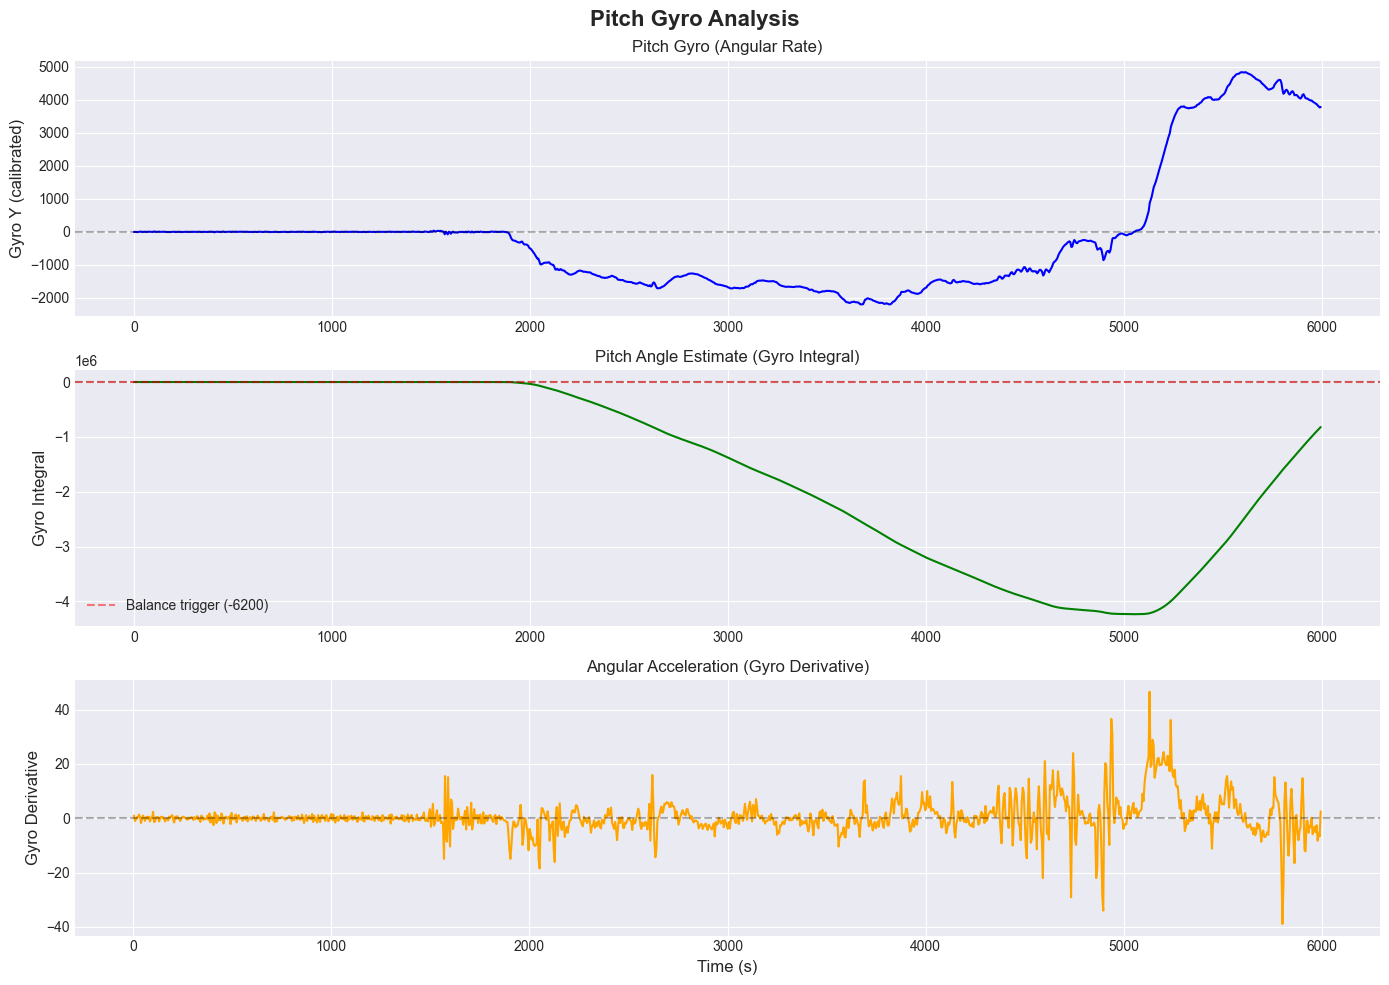

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Pitch Gyro Analysis', fontsize=16, fontweight='bold')

# Plot 1: Gyro Y (pitch rate)
ax1.plot(df['time_s'], df['gyro_y'], linewidth=1.5, color='blue')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_ylabel('Gyro Y (calibrated)', fontsize=12)
ax1.set_title('Pitch Gyro (Angular Rate)', fontsize=12)
ax3.grid(True)

# Plot 2: Gyro Integral (angle estimate)
ax2.plot(df['time_s'], df['gyro_integral'], linewidth=1.5, color='green')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axhline(y=-6200, color='r', linestyle='--', alpha=0.5, label='Balance trigger (-6200)')
ax2.set_ylabel('Gyro Integral', fontsize=12)
ax2.set_title('Pitch Angle Estimate (Gyro Integral)', fontsize=12)
ax2.legend()
ax3.grid(True)

# Plot 3: Gyro Derivative (angular acceleration)
ax3.plot(df['time_s'], df['gyro_derivative'], linewidth=1.5, color='orange')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Gyro Derivative', fontsize=12)
ax3.set_title('Angular Acceleration (Gyro Derivative)', fontsize=12)
ax3.grid(True)

plt.tight_layout()
plt.show()

420    124892280
421    124897358
422    124902436
423    124907516
424    124912594
425    124917672
426    124922750
427    124927830
428    124932908
429    124937986
430    124943064
431    124948144
432    124953222
433    124958300
434    124963378
435    124968458
436    124973536
437    124978614
438    124983692
439    124988772
440    124993851
441    124998931
442    125004009
443    125009087
444    125014165
445    125019245
446    125024323
447    125029402
448    125034482
449    125039560
450    125044638
451    125049716
452    125054796
453    125059874
454    125064952
455    125070030
456    125075110
457    125080188
458    125085266
459    125090347
Name: time_us, dtype: int64


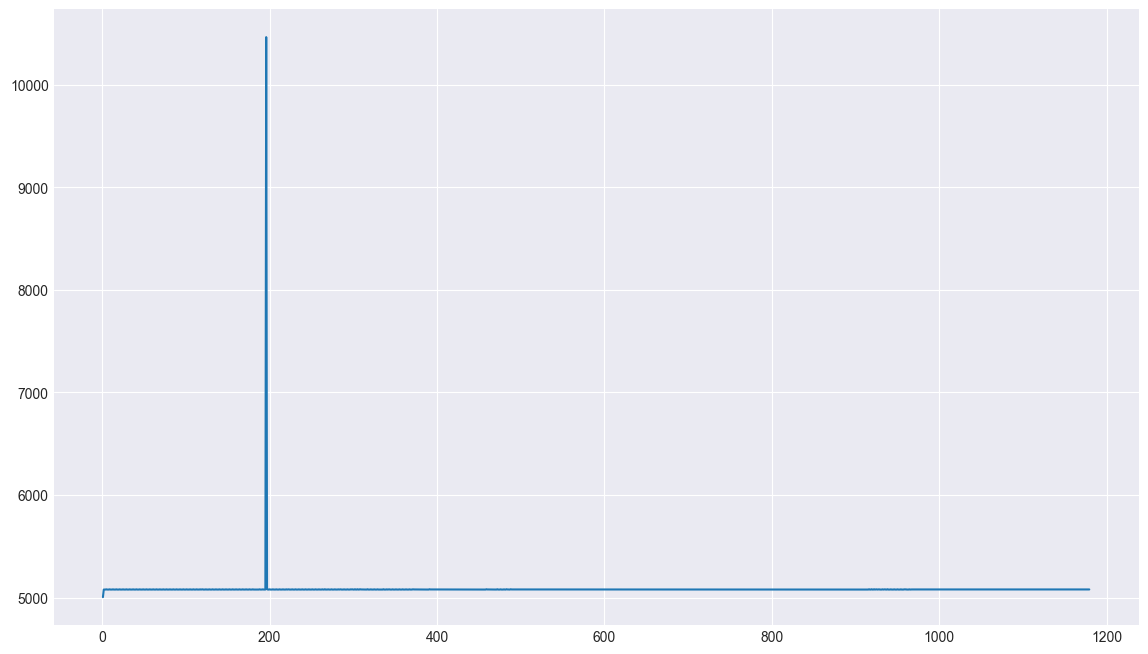

In [61]:
dt = df['time_us'].diff()
plt.plot(dt)
print(df['time_us'][420:460])

## Cell 4: Plot Encoder Positions and Velocities

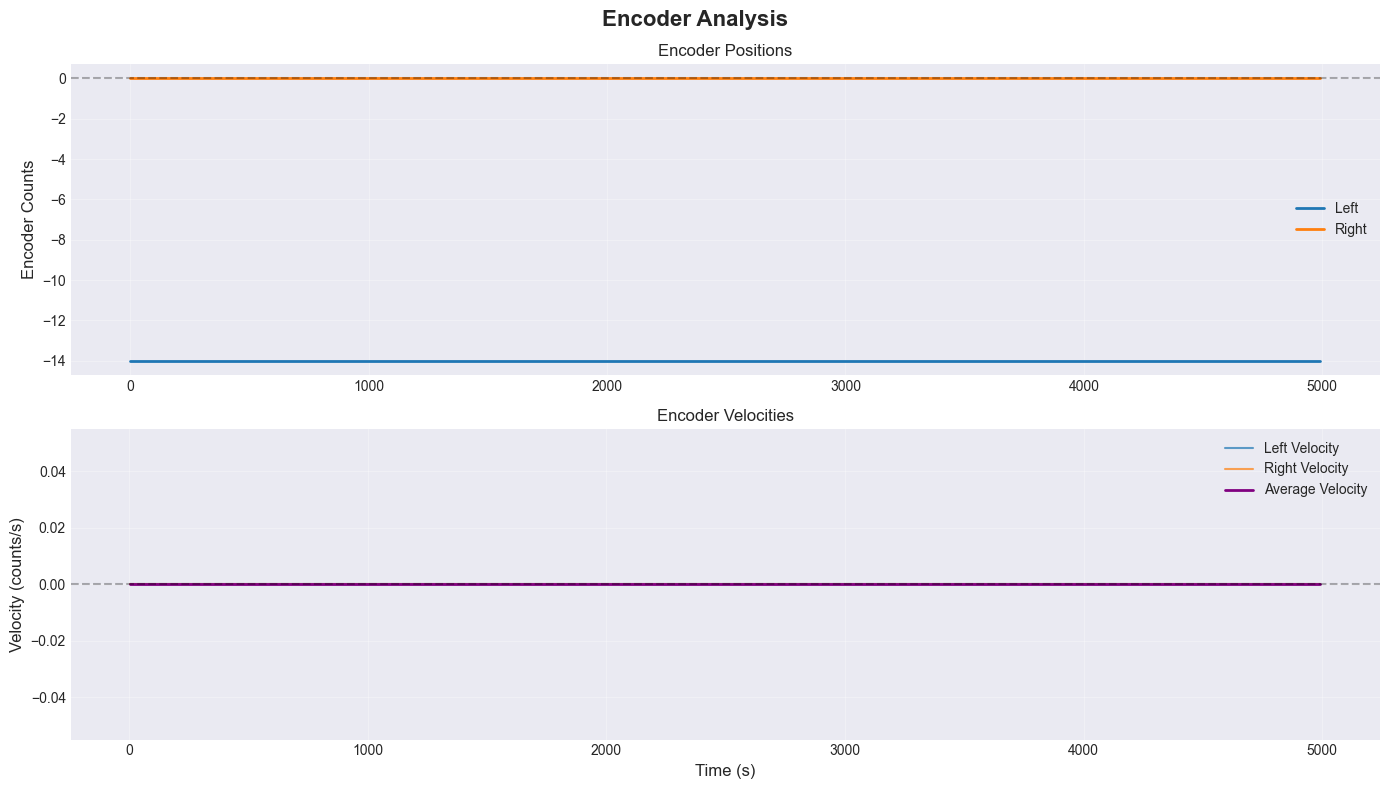

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
fig.suptitle('Encoder Analysis', fontsize=16, fontweight='bold')

# Plot 1: Encoder positions
ax1.plot(df['time_s'], df['leftenc'], label='Left', linewidth=2)
ax1.plot(df['time_s'], df['rightenc'], label='Right', linewidth=2)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_ylabel('Encoder Counts', fontsize=12)
ax1.set_title('Encoder Positions', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Velocities
ax2.plot(df['time_s'], df['left_vel'], label='Left Velocity', linewidth=1.5, alpha=0.7)
ax2.plot(df['time_s'], df['right_vel'], label='Right Velocity', linewidth=1.5, alpha=0.7)
ax2.plot(df['time_s'], df['avg_vel'], label='Average Velocity', linewidth=2, color='purple')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Velocity (counts/s)', fontsize=12)
ax2.set_title('Encoder Velocities', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 5: Plot Commanded vs Observed Speed

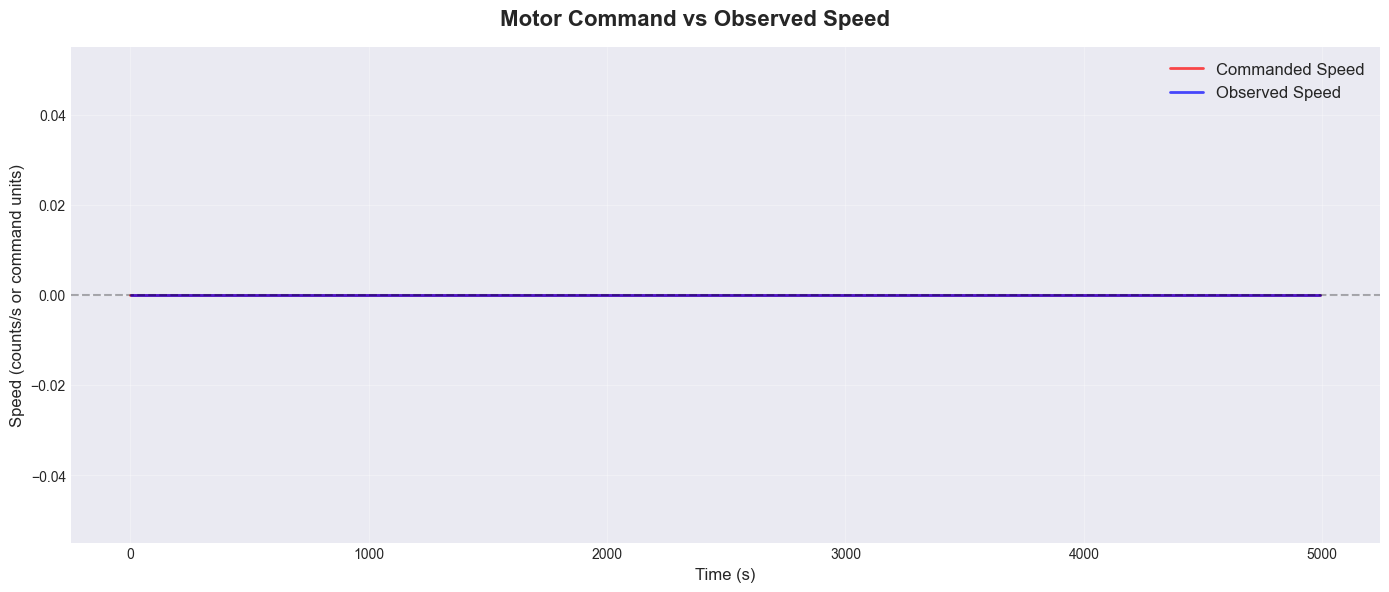

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle('Motor Command vs Observed Speed', fontsize=16, fontweight='bold')

ax.plot(df['time_s'], df['motorcmd'], label='Commanded Speed', linewidth=2, color='red', alpha=0.7)
ax.plot(df['time_s'], df['avg_vel'], label='Observed Speed', linewidth=2, color='blue', alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Speed (counts/s or command units)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 6: Plot PID Components

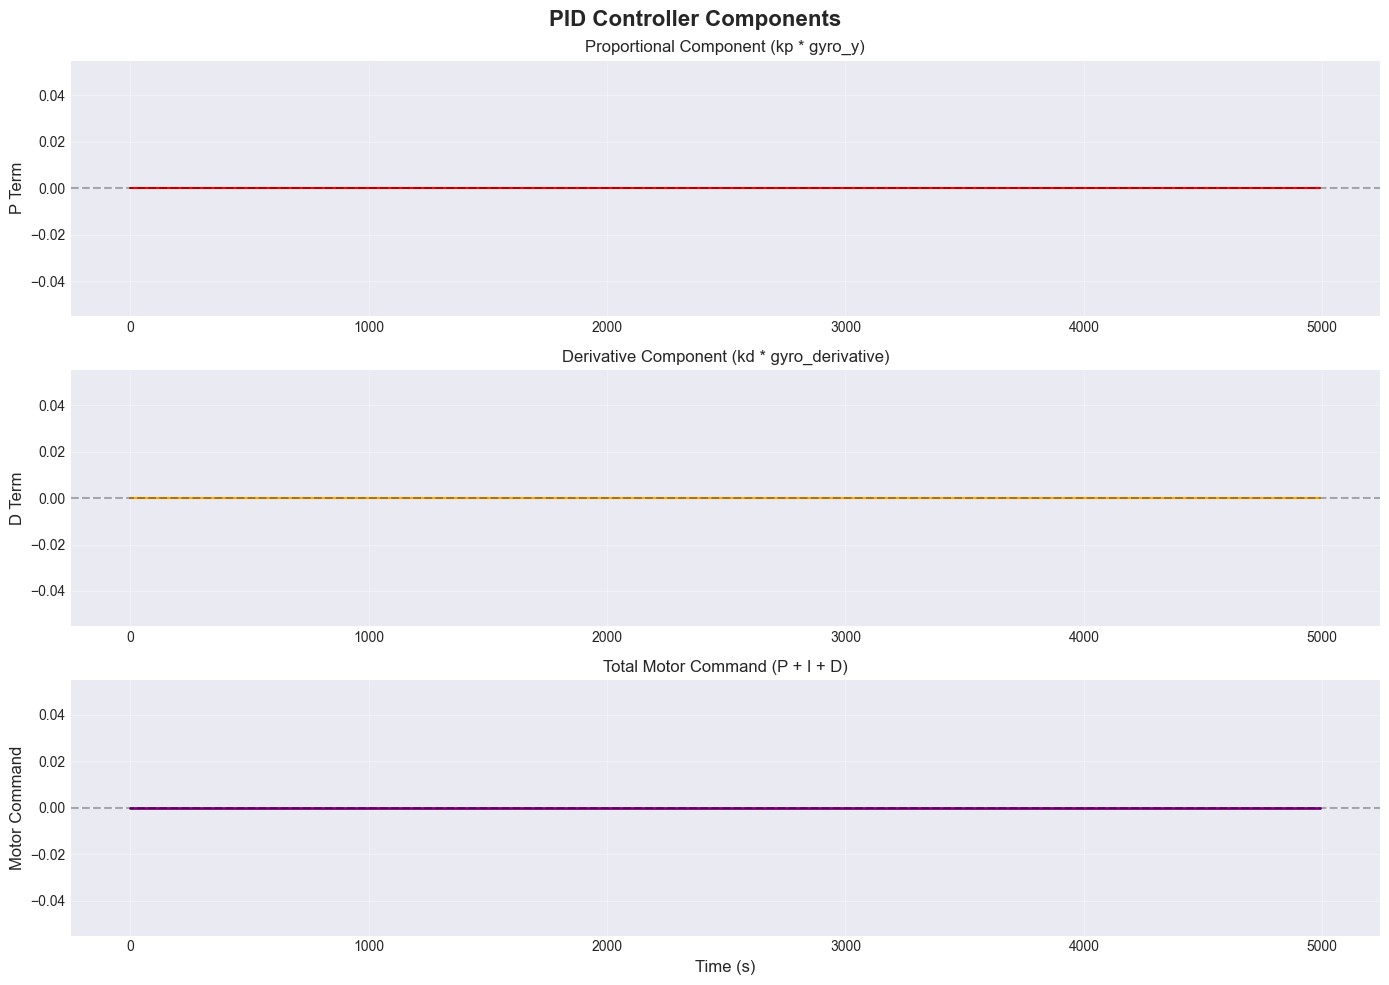

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('PID Controller Components', fontsize=16, fontweight='bold')

# Plot 1: P component
ax1.plot(df['time_s'], df['pid_p'], linewidth=1.5, color='red')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_ylabel('P Term', fontsize=12)
ax1.set_title('Proportional Component (kp * gyro_y)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: D component
ax2.plot(df['time_s'], df['pid_d'], linewidth=1.5, color='orange')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_ylabel('D Term', fontsize=12)
ax2.set_title('Derivative Component (kd * gyro_derivative)', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Motor command (P + I + D)
ax3.plot(df['time_s'], df['motorcmd'], linewidth=2, color='purple')
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Motor Command', fontsize=12)
ax3.set_title('Total Motor Command (P + I + D)', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 7: Plot All PID Components Together

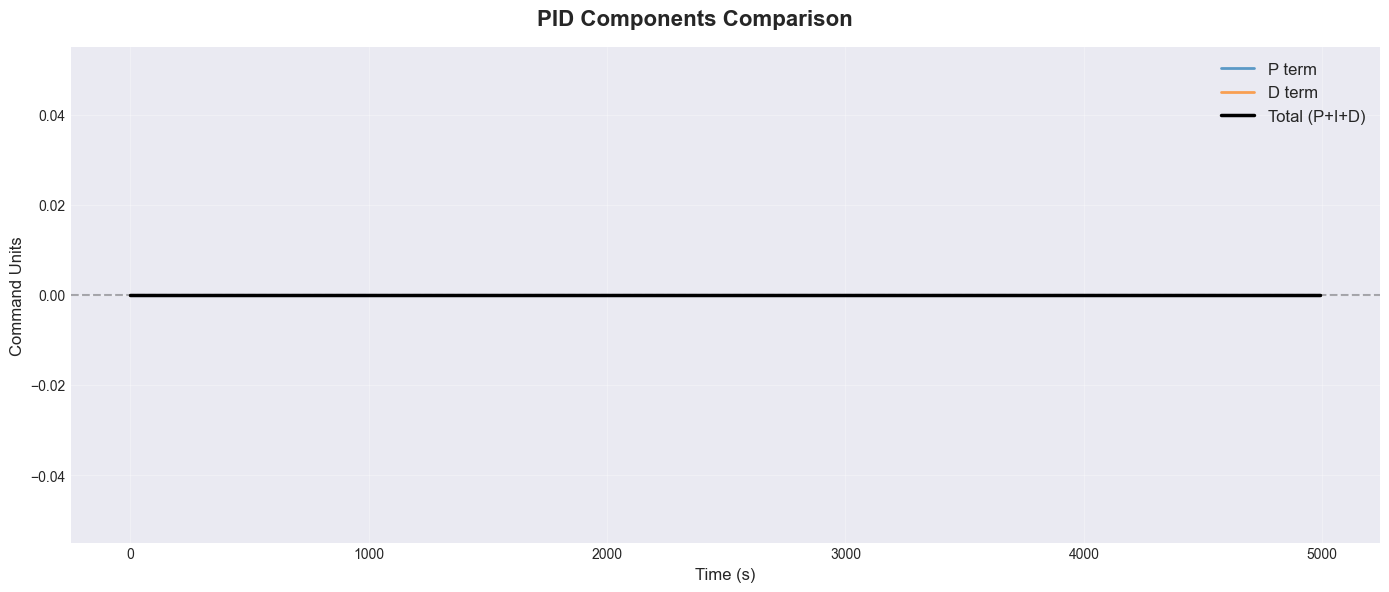

In [26]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle('PID Components Comparison', fontsize=16, fontweight='bold')

ax.plot(df['time_s'], df['pid_p'], label='P term', linewidth=2, alpha=0.7)
ax.plot(df['time_s'], df['pid_d'], label='D term', linewidth=2, alpha=0.7)
ax.plot(df['time_s'], df['motorcmd'], label='Total (P+I+D)', linewidth=2.5, color='black')
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Command Units', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Note: I term = motorcmd - pid_p - pid_d (if you want to see it)
df['pid_i_estimated'] = df['motorcmd'] - df['pid_p'] - df['pid_d']

## Cell 9: Phase Portrait (Gyro vs Gyro Integral)

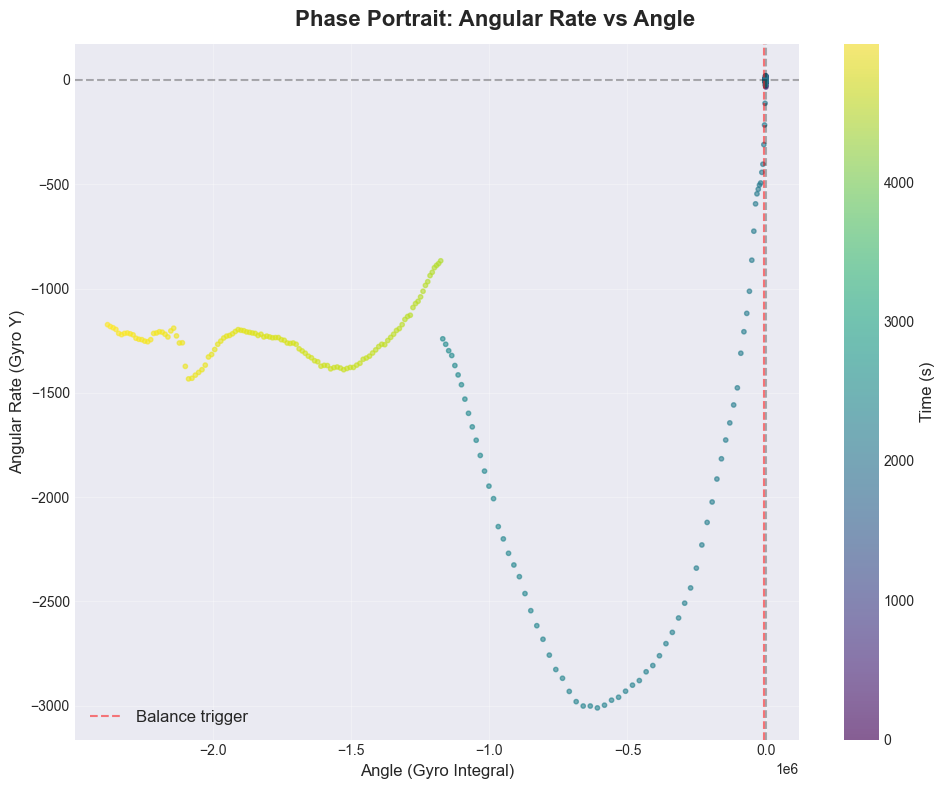

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle('Phase Portrait: Angular Rate vs Angle', fontsize=16, fontweight='bold')

# Color by time
scatter = ax.scatter(df['gyro_integral'], df['gyro_y'], 
                     c=df['time_s'], cmap='viridis', alpha=0.6, s=10)

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
ax.axvline(x=-6200, color='r', linestyle='--', alpha=0.5, label='Balance trigger')

ax.set_xlabel('Angle (Gyro Integral)', fontsize=12)
ax.set_ylabel('Angular Rate (Gyro Y)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Time (s)', fontsize=12)

plt.tight_layout()
plt.show()

## Cell 10: Zoom on Specific Time Range (Optional)

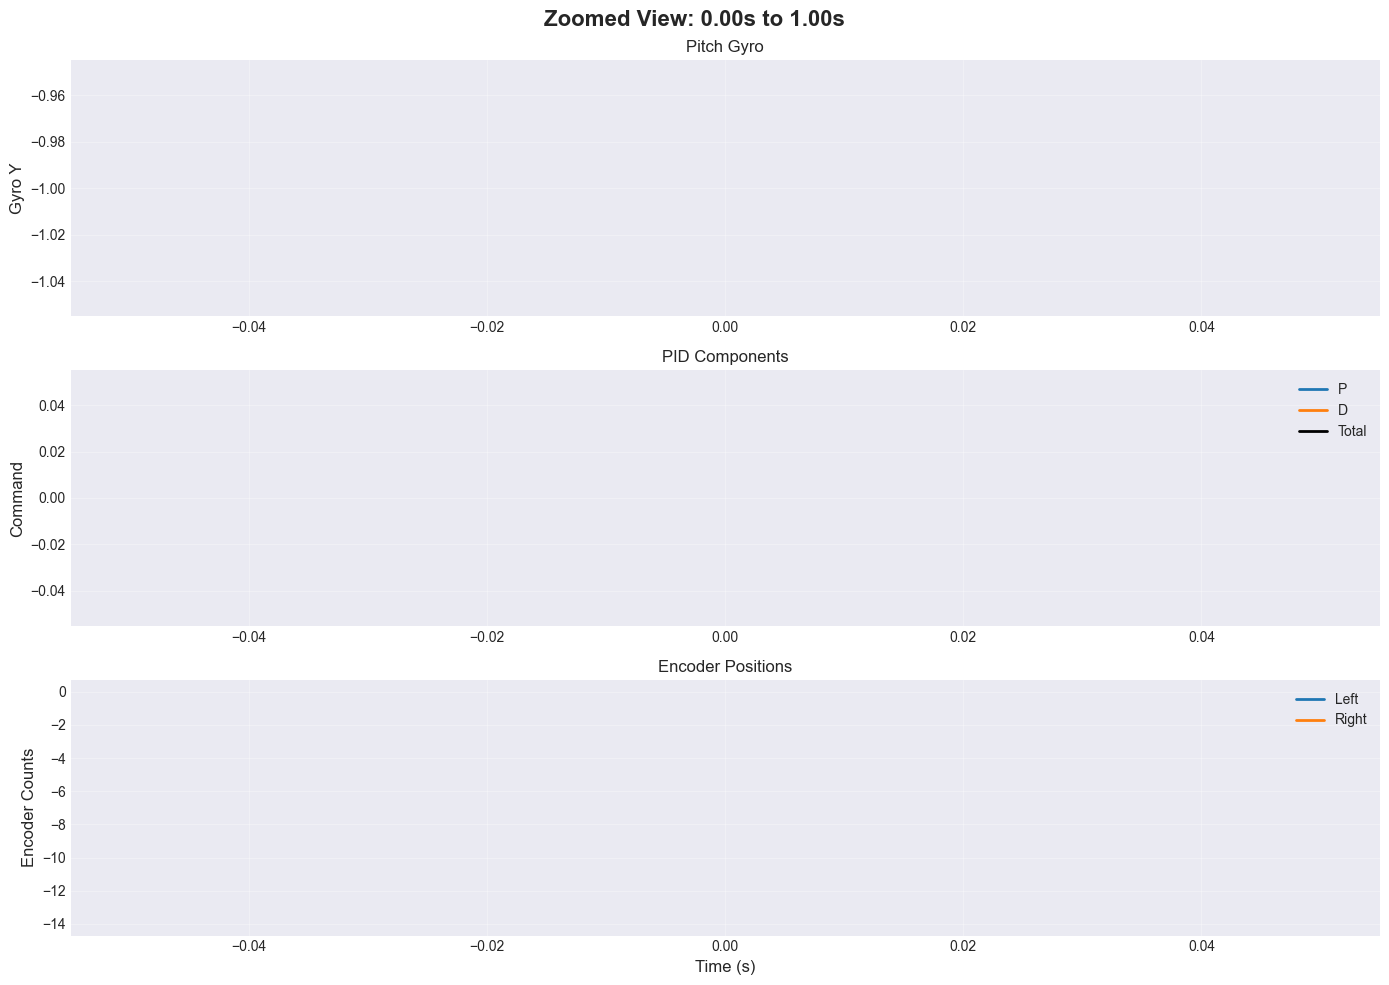

In [28]:
# Adjust these to zoom on a specific time range
t_start = 0.0  # seconds
t_end = 1.0    # seconds

mask = (df['time_s'] >= t_start) & (df['time_s'] <= t_end)
df_zoom = df[mask]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle(f'Zoomed View: {t_start:.2f}s to {t_end:.2f}s', fontsize=16, fontweight='bold')

# Gyro
ax1.plot(df_zoom['time_s'], df_zoom['gyro_y'], linewidth=2)
ax1.set_ylabel('Gyro Y', fontsize=12)
ax1.set_title('Pitch Gyro', fontsize=12)
ax1.grid(True, alpha=0.3)

# Motor command and PID components
ax2.plot(df_zoom['time_s'], df_zoom['pid_p'], label='P', linewidth=2)
ax2.plot(df_zoom['time_s'], df_zoom['pid_d'], label='D', linewidth=2)
ax2.plot(df_zoom['time_s'], df_zoom['motorcmd'], label='Total', linewidth=2, color='black')
ax2.set_ylabel('Command', fontsize=12)
ax2.set_title('PID Components', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Encoders
ax3.plot(df_zoom['time_s'], df_zoom['leftenc'], label='Left', linewidth=2)
ax3.plot(df_zoom['time_s'], df_zoom['rightenc'], label='Right', linewidth=2)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Encoder Counts', fontsize=12)
ax3.set_title('Encoder Positions', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

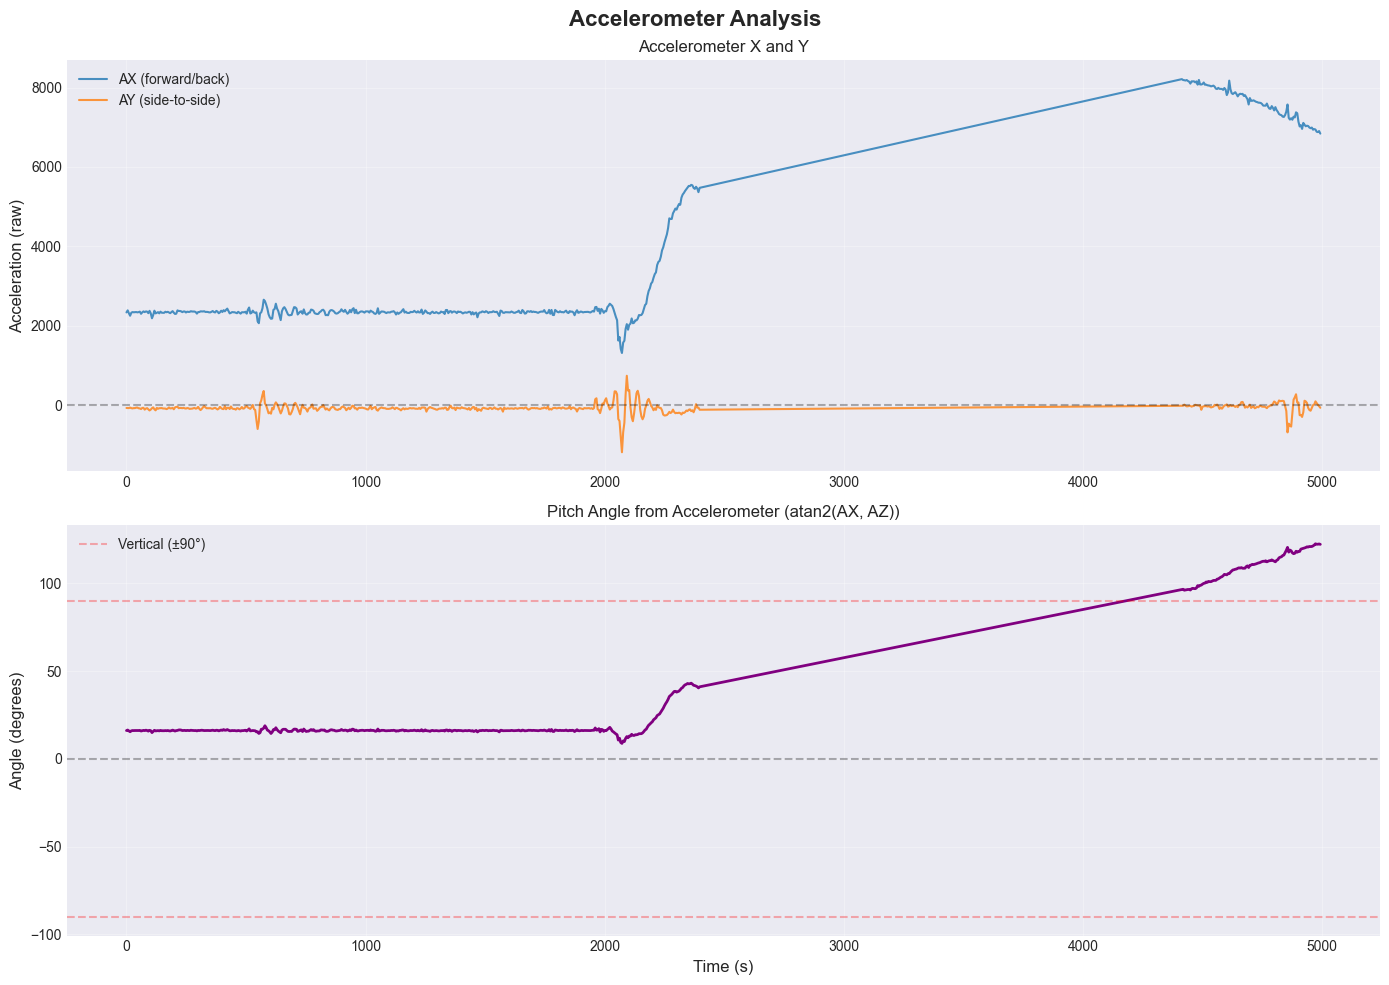

Accelerometer angle statistics:
  Mean:  35.74°
  Std:   37.09°
  Min:    8.85°
  Max:  122.55°


In [29]:
# Compute angle from accelerometer and plot accelerations
import numpy as np

# Compute pitch angle from accelerometer
# When stationary, accelerometer measures gravity component
# pitch angle = atan2(forward_accel, vertical_accel)
df['accel_angle_rad'] = np.arctan2(df['ax'], df['az'])
df['accel_angle_deg'] = df['accel_angle_rad'] * 180 / np.pi

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Accelerometer Analysis', fontsize=16, fontweight='bold')

# Plot 1: Accelerometer X and Y
ax1.plot(df['time_s'], df['ax'], label='AX (forward/back)', linewidth=1.5, alpha=0.8)
ax1.plot(df['time_s'], df['ay'], label='AY (side-to-side)', linewidth=1.5, alpha=0.8)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.set_ylabel('Acceleration (raw)', fontsize=12)
ax1.set_title('Accelerometer X and Y', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Pitch angle from accelerometer
ax2.plot(df['time_s'], df['accel_angle_deg'], linewidth=2, color='purple')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axhline(y=90, color='r', linestyle='--', alpha=0.3, label='Vertical (±90°)')
ax2.axhline(y=-90, color='r', linestyle='--', alpha=0.3)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Angle (degrees)', fontsize=12)
ax2.set_title('Pitch Angle from Accelerometer (atan2(AX, AZ))', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Accelerometer angle statistics:")
print(f"  Mean: {df['accel_angle_deg'].mean():6.2f}°")
print(f"  Std:  {df['accel_angle_deg'].std():6.2f}°")
print(f"  Min:  {df['accel_angle_deg'].min():6.2f}°")
print(f"  Max:  {df['accel_angle_deg'].max():6.2f}°")